## Creating features for opennmt-py

We're going to eventually make this into a function as part of the whole data cleaning process, assuming it works. 
This means we will use keyword variables at the top in substitute for arguments.

### Progress

We originally tried doing this with the subword encoded text and with the words as additional features, using | syntax for opennmt. Now we're moving on to trying to append the words into the input sequence. Since that seems more strongly likely to have a direct impact. While this may or may not work, we will extend into using pretrained word vectors if there's not enough information in the examples for the model to learn the syntax correctly. 



In [33]:
# import any modules
import os
import random
import string
from collections import Counter


First we do all the preparation using the training data

In [34]:
# function arguments 
source_file_name = "/home/henrye/projects/E2E/data/trainset-source.tok"
target_file_name = "/home/henrye/projects/E2E/data/trainset-target.tok"

In [35]:
with open(source_file_name, 'r') as source_file:
    source = [line.split() for line in source_file.readlines()]

with open(target_file_name, 'r') as target_file:
    target = [line.split() for line in target_file.readlines()]
    

###  Messing around with what to use as additional word input
We don't want to go over board. Not allowing numbers seems like a good addition. We're considering also removing words which reference children. But maybe it's because of the variety of ways people refer to child friendliness that results in it being left out of the results quite often. We'll wait and see about that I think. In fact what we're starting to see is a large divergence of different ways people refer to child friendliness. Which might explain why it doesn't appear as frequently in the output as the other categories.

We've had to do some messing about with the stop word tokens, partly because they're not tokenized and the data isn't lower cased. For now we're not going to lower case the source sequences. But we might in the future if we start using pretrained vectors from fasttext.

We're considering splitting apart words with hyphens between them. Or at least maybe doing it to numbers with hyphens. Since that would make reasonable sense. Kind of like sub word stuff.

For future consideration we might considering limiting the vocab to words that appear a minimum number of times. 

Other things to keep in mind is that some people use american spelling. And also sometimes words are repeated. So maybe only unique tokens? Or turn the list into a set and then back again.


In [36]:
def find_target_valid_tokens(source, target):
    # creating a unique flat list https://stackoverflow.com/a/952952/4507677
    source_tokens = list(set(token for tokens in source for token in tokens))
    source_categories = ['name', 'area', 'family', 'friendly', 'near', 'customer', 'rating', 'eat', 'type', 'food', 'price', 'range',]
    # there's words here with apostrephes but we'll deal with that later this is a rough first go
    stop_words = ['-', '\'', ';', ',', '.', '\'s', '\'t', '\'ll', '\'re', 'ourselves', 'out', 'over', 'own', 'same', 'shan', 't', 'she', 'she', 'd', 'she', 'll', 'she', 's', 'should', 'shouldn', 't', 'so', 'some', 'such', 'than', 'that', 'that', 's', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'there', 's', 'these', 'they', 'they', 'd', 'they', 'll', 'they', 're', 'they', 've', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'wasn', 't', 'we', 'we', 'd', 'we', 'll', 'we', 're', 'we', 've', 'were', 'weren', 't', 'what', 'what', 's', 'when', 'when', 's', 'where', 'where', 's', 'which', 'while', 'who', 'who', 's', 'whom', 'why', 'why', 's', 'with', 'won', 't', 'would', 'wouldn', 't', 'you', 'you', 'd', 'you', 'll', 'you', 're', 'you', 've', 'your', 'yours', 'yourself', 'yourselves', 'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', 't', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 't', 'cannot', 'could', 'couldn', 't', 'did', 'didn', 't', 'do', 'does', 'doesn', 't', 'doing', 'don', 't', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', 't', 'has', 'hasn', 't', 'have', 'haven', 't', 'having', 'he', 'he', 'd', 'he', 'll', 'he', 's', 'her', 'here', 'here', 's', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'how', 's', 'i', 'i', 'd', 'i', 'll', 'i', 'm', 'i', 've', 'if', 'in', 'into', 'is', 'isn', 't', 'it', 'it', 's', 'its', 'itself', 'let', 's', 'me', 'more', 'most', 'mustn', 't', 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours']
    all_tokens_to_ignore = source_tokens + source_categories + stop_words
    def hasNumbersOrPunctuation(inputString):
        return any(char.isdigit() or char in string.punctuation for char in inputString)

    target_valid_tokens = []
    for k, line in enumerate(target):
        target_valid_tokens += [[]]
        for token in line:
            if token not in all_tokens_to_ignore and token.lower() not in all_tokens_to_ignore and len(token) > 1 and not hasNumbersOrPunctuation(token):
                target_valid_tokens[k] += [token]
    return target_valid_tokens

In [37]:
target_valid_tokens = find_target_valid_tokens(source, target)

### Limiting the number of available words

Getting rid of the most frequent words, or really just `located` for now. We will remove more of the most frequent tokens if it still remains a problem

Considering making all the words lower case. That way we could get a more realistic count for the number of times a word appears. At the same time an uppercase word does indicate that it's used in a different position than normal. So I kind of also like that for inducing diversity. We'll see what the model output looks like. 

In [38]:
valid_tokens = list(list(token for tokens in target_valid_tokens for token in tokens))
unique_valid_tokens = list(set(valid_tokens))
print("right number of tokens? ", len(unique_valid_tokens) == 2487)
count_of_valid_tokens = Counter(valid_tokens)

right number of tokens?  True


In [39]:
min_feature_token_frequency = 6
for token, count in count_of_valid_tokens.most_common():
    if count < min_feature_token_frequency and token in unique_valid_tokens:
        print(token, count)
        unique_valid_tokens.remove(token)
unique_valid_tokens.remove('located')  

luxurious 5
overlooking 5
Zizzis 5
Featuring 5
locates 5
native 5
keep 5
tends 5
miles 5
charge 5
shopping 5
entertainment 5
super 5
another 5
hungry 5
pastas 5
Cheaply 5
Dishes 5
sitting 5
enjoying 5
wrestlers 5
hold 5
finest 5
int 5
curry 5
array 5
exceed 5
begin 5
giving 5
whit 5
penny 5
costumers 5
various 5
guests 5
especially 5
school 5
breads 5
Watermans 5
attitude 5
hard 5
visited 5
approved 5
anyone 5
consumers 5
exquisite 5
mixed 5
Given 5
receive 5
desired 5
Us 5
unique 5
rivers 5
fond 5
Euro 5
accept 5
provider 5
excellently 5
accommodate 5
equally 5
Reasonably 5
kind 5
Aromis 5
suggest 5
ad 5
went 5
complete 5
Around 5
Typically 5
Higher 5
university 5
blocks 5
alcoholic 5
leaves 5
company 5
hot 5
supplies 5
stay 5
mainly 5
either 5
deal 5
ear 5
Sicilian 5
run 5
featured 5
catered 5
Indiana 5
hear 5
types 5
Delicious 4
taking 4
possible 4
minors 4
bought 4
maybe 4
eaten 4
Environment 4
sample 4
modern 4
standards 4
takeout 4
parents 4
Traditional 4
dear 4
parties 4
exceedi

In [40]:
reduced_target_valid_tokens = []
for k, line in enumerate(target_valid_tokens):
    reduced_target_valid_tokens += [[]]
    if line:
        for token in line:
            if token in unique_valid_tokens:
                reduced_target_valid_tokens[k] += [token]

experimenting around with seeing what tokens appear. Like we said above, it's mostly kid related stuff. People have wildly varying ways of describing kid friendliness 

### Data analysis on the tokens

There's a bunch of different things I'd like to do to understand the extra words we're going to be using. We've already include some code to see distribution of how many additional word there are per sentence.

The other stuff is a distribution of the additional words themselves. Stuff I'm seeing from looking at the words. I don't understand how if we've put them through the tokenizer there's so many words with a fullstop at the end. 

The other thing I'm thinking about dealing with is the "-" dash. It's inbetween a lot 

In [41]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

 
# We're going to look into using Pandas for better data analysis 
# for i in range(0, 50):
#  print(i, [len(tokens) for tokens in target_valid_tokens].count(i))

# update to reflect the new tokens we've removed
reduced_valid_tokens = list(list(token for tokens in reduced_target_valid_tokens for token in tokens))
count_of_reduced_valid_tokens = Counter(reduced_valid_tokens)

# unique_valid_tokens
for i in range(0, 23):
 print(i, [len(tokens) for tokens in reduced_target_valid_tokens].count(i))
this = 0

# for line in reduced_target_valid_tokens:
#     if len(line) > 13:
#         print(line)
#         this += 1
#     if this > 100:
#         break

print(len(unique_valid_tokens))
pp.pprint(unique_valid_tokens)
pp.pprint(count_of_reduced_valid_tokens)

0 3728
1 10180
2 9496
3 7458
4 4964
5 2864
6 1638
7 803
8 458
9 236
10 107
11 51
12 34
13 20
14 13
15 6
16 3
17 1
18 1
19 0
20 0
21 0
22 0
759
[   'money',
    'next',
    'however',
    'burger',
    'fair',
    'edge',
    'although',
    'satisfaction',
    'Good',
    'across',
    'servers',
    'moment',
    'beans',
    'thats',
    'quaint',
    'order',
    'reasonable',
    'yet',
    'try',
    'level',
    'averaging',
    'alternative',
    'rage',
    'alongside',
    'falls',
    'sold',
    'plus',
    'bill',
    'outstanding',
    'specializes',
    'usually',
    'named',
    'offerings',
    'ratings',
    'Pasta',
    'burgers',
    'get',
    'fall',
    'bread',
    'catering',
    'convenient',
    'due',
    'orientated',
    'space',
    'zone',
    'couples',
    'hamburger',
    'dollars',
    'Receiving',
    'unsuitable',
    'northern',
    'Wine',
    'exclusive',
    'tastes',
    'pay',
    'stars',
    'glass',
    'something',
    'upwards',
    'set

    'makes',
    'bad',
    'best',
    'upper',
    'themed',
    'found',
    'Nearby',
    'Look',
    'healthy',
    'opposite',
    'stunning',
    'Rated',
    'earned',
    'scored',
    'house',
    'warm',
    'Situated',
    'Oriented',
    'new',
    'consumer',
    'recommend',
    'may',
    'love',
    'class',
    'premium',
    'needs',
    'bank',
    'scale',
    'Public',
    'chop',
    'perhaps',
    'Oriental',
    'river',
    'better',
    'little',
    'feature',
    'bite',
    'Beside',
    'Offering',
    'ate',
    'menu',
    'grab',
    'small',
    'drinking',
    'Poorly',
    'recommended',
    'breakfasts',
    'variety',
    'usual',
    'home',
    'Asian',
    'receives',
    'Costing',
    'cool',
    'ranging',
    'choose',
    'Want',
    'holds',
    'given',
    'meet',
    'breakfast',
    'selling',
    'gets',
    'ever',
    'staying',
    'Affordable',
    'affordable',
    'dishes',
    'taste',
    'cuisine',
    'standard',
    'great

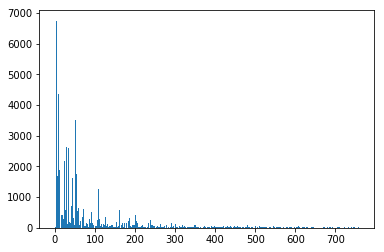

In [42]:
import numpy as np
import matplotlib.pyplot as plt


labels, values = zip(*count_of_reduced_valid_tokens.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
# plt.xticks(indexes + width * 0.5, labels)
plt.show()

## Creating output and writing to file

In [43]:
source_output = []
for k, line in enumerate(source):
    source_output += [[]]
    # add the existing line to the list
    # add the extra tokens to the list too
    source_output[k] += line
    if len(reduced_target_valid_tokens[k]) > 0:
        source_output[k] += ['__start_additional_words__']
        source_output[k] += reduced_target_valid_tokens[k]
        source_output[k] += ['__end_additional_words__']

In [44]:
with open("data/trainset-source.tok.extracted_feat", "w") as source_output_file:
    for line in source_output:
        source_output_file.write(' '.join(line) + "\n")


### This is for writing the feature generating model files 

In [45]:
# -additional-words-source.tok
source_file_name = "/home/henrye/projects/E2E/data/trainset-additional-words-source.tok"
with open(source_file_name, 'r') as source_file:
    source = [line.split() for line in source_file.readlines()]

with open("data/trainset-additional-words-source.tok.filter", 'w') as source_output_file:
    with open("data/trainset-additional-words-target.tok.filter", 'w') as target_output_file:
        for source, target in zip(source, reduced_target_valid_tokens):
            if target:
                target_output_file.write(' '.join(target) + '\n')
                source_output_file.write(' '.join(source) + '\n')

### Devset feature creation

We kind of lazily reused a lot of the above code and variable names but changed some of the stuff. Like `unique_valid_tokens`. This could be a lot smarter. For example a lot of the stuff that appears probably doesn't make sense in the context. 

In [46]:
# function arguments 
source_file_name = "/home/henrye/projects/E2E/data/devset-source.tok"
target_file_name = "/home/henrye/projects/E2E/data/devset-target.tok"

In [47]:
with open(source_file_name, 'r') as source_file:
    source = [line.split() for line in source_file.readlines()]

with open(target_file_name, 'r') as target_file:
    target = [line.split() for line in target_file.readlines()]

In [48]:
target_valid_tokens = []
for k, line in enumerate(target):
    target_valid_tokens += [[]]
    for token in line:
        if token in unique_valid_tokens:
            target_valid_tokens[k] += [token]

In [49]:
source_output = []
for k, line in enumerate(source):
    source_output += [[]]
    # add the existing line to the list
    # add the extra tokens to the list too
    source_output[k] += line
    if len(target_valid_tokens[k]) > 0:
        source_output[k] += ['__start_additional_words__']
        source_output[k] += target_valid_tokens[k]
        source_output[k] += ['__end_additional_words__']

In [50]:
with open("data/devset-source.tok.extracted_feat", "w") as source_output_file:
    for line in source_output:
        source_output_file.write(' '.join(line) + "\n")

In [52]:
# -additional-words-source.tok
source_file_name = "/home/henrye/projects/E2E/data/devset-additional-words-source.tok"
with open(source_file_name, 'r') as source_file:
    source = [line.split() for line in source_file.readlines()]

with open("data/devset-additional-words-source.tok.filter", 'w') as source_output_file:
    with open("data/devset-additional-words-target.tok.filter", 'w') as target_output_file:
        for source, target in zip(source, target_valid_tokens):
            if target:
                target_output_file.write(' '.join(target) + '\n')
                source_output_file.write(' '.join(source) + '\n')

## Repeat for unique source sequences

We're repeating the whole process for unique source sentences. This isn't how we will be doing things long run. At least until we get the RNN set up so we're not turning it into a function. Still kind of going by Hadley's thing of having to do something more than 2 or 3 times in order to warrant creating a function.

This was something we did for testing out what generated extracted features might look like if we used them

In [ ]:
target_valid_tokens

In [ ]:
# https://stackoverflow.com/a/15990766/4507677 - we do this to preserve the order of the sentences
unique_source = []
additional_words = []
for source_line, target_line in zip(source, target_valid_tokens):
    if source_line not in unique_source:
        unique_source.append(source_line)
        additional_words.append(target_line)
# [unique_source.append(item) for item, target in zip(source, target_valid_tokens) if item not in unique_source]

print(len(unique_source) == 547, len(unique_source))

We have a list of features / additional words generated by a model. We're going to add them to the `devset-source.tok.unique` file manually

In [ ]:
# additional_words = ['serves', 'located', 'serves', 'located', 'serves', 'located', 'serves', 'located', 'kid', 'kid', 'serves', 'serves', 'serves', 'kid', 'serves', 'kid', 'serves', 'serves', 'serves', 'serves', 'kid', 'serves', 'serves', 'kid', 'kid', 'serves', 'serves', 'serves', 'kid', 'serves', 'kid', 'serves', 'serves', 'serves', 'serves', 'kid', 'serves', 'serves', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'serves', 'kid', 'serves', 'kid', 'serves', 'serves', 'serves', 'kid', 'serves', 'serves', 'serves', 'kid', 'serves', 'kid', 'serves', 'kid', 'serves', 'kid', 'serves', 'kid', 'serves', 'kid', 'serves', 'serves', 'serves', 'kid', 'serves', 'serves', 'serves', 'kid', 'serves', 'kid', 'serves', 'kid', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'serves', 'serves', 'serves', 'kid', 'kid', 'kid', 'kid', 'kid', 'serves', 'serves', 'serves', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'serves', 'serves', 'serves', 'kid', 'kid', 'kid', 'kid', 'kid', 'serves', 'serves', 'serves', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'kid', 'serves', 'serves', 'serves', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'serves', 'serves', 'serves', 'serves', 'serves', 'serves', 'serves', 'serves', 'serves', 'serves', 'serves', 'serves', 'serves', 'serves', 'serves', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'serves', 'located', 'serves', 'located', 'serves', 'located', 'serves', 'located', 'serves', 'located', 'serves', 'located', 'serves', 'located', 'serves', 'located', 'serves', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'located', 'serves', 'located', 'serves', 'located', 'located', 'located', 'located', 'located', 'located', 'serves', 'located', 'serves', 'located', 'located', 'located']
print(len(additional_words) == 547, len(additional_words))

In [ ]:
source_output = []
for k, line in enumerate(unique_source):
    source_output += [[]]
    source_output[k] += line
    if additional_words[k]:
        source_output[k] += ['__start_additional_words__']
        source_output[k] += additional_words[k]
        source_output[k] += ['__end_additional_words__']

In [ ]:
with open("data/devset-source.tok.unique.feat", "w") as source_output_file:
    for line in source_output:
        source_output_file.write(' '.join(line) + "\n")
        
with open("data/devset-source.tok.unique", "w") as source_output_file:
    for line in unique_source:
        source_output_file.write(' '.join(line) + "\n")

This is what it looked like when we used features

In [ ]:
source_output = []
for k, line in enumerate(source):
    source_output += [[]]
    random_word_feature = random.choice(unique_valid_tokens)
    for token in line:
        source_output[k] += [token + "￨" + random_word_feature]